# Final Import Zillow Data
## Brian Goggin
In this assignment, I import data from the San Francisco development pipeline from SF Open data's API. I import quarterly data from the fourth quarter of 2012 to the second quarter of 2016. In the first section of the notebook, I import, append, and clean the data. In other notebooks, I use this data to explore development activity in SF. 

# Section 1: Import and Clean Data

First, import the packages necessary for calling an API. 

In [125]:
#import packages
import pandas as pd
import numpy as np
import os
import matplotlib as mil
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

In [126]:
#set directory
root = "/Users/briangoggin/Dropbox/CP 255/SF Development Project/"

In [127]:
#import data
import_file = root+"Raw Data/Zillow Rent Data/Neighborhood_Zri_AllHomesPlusMultifamily.csv"
rent = pd.read_csv(import_file)

In [128]:
#keep only observations from SF
rent = rent[rent['City'] == 'San Francisco']
#rent.head(20)

In [129]:
#Keep only certain months
columns = ['2010-11', '2010-12', '2011-01', '2011-02','2011-03', '2011-04','2011-05',
           '2011-06','2011-07', '2011-08','2011-09', '2011-10','2011-11','2011-12',
           '2012-01','2012-02', '2012-03','2012-04','2012-05','2012-06','2012-07',
           '2012-08','2012-09','2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
           '2016-09']

rent.drop(columns, axis = 1, inplace = True)
#rent.head()

In [130]:
#Compute change in rent metric
rent['change'] = 100*((rent['2016-03'] - rent['2012-10'])/rent['2012-10'])
#rent.head(10)

In [131]:
#compute average rent
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
years = ['2013' ,'2014', '2015']
columns = []
for y in years:
    for m in months:
        columns.append(y+'-'+m)

moreyears = ['2012-10', '2012-11', '2012-12', '2016-01', '2016-02','2016-03']

for i in moreyears:
    columns.append(i)
    
rent['avg_rent'] = rent[columns].mean(axis=1)

# Section 2. Analysis and Figures

In [132]:
units = pd.read_csv(root+"Intermediate Files/completed.csv")
units.drop(['NAME', 'REGIONID', 'geometry'], axis = 1, inplace = True)


In [133]:
# Merge data. Left with only 29 observations after this but oh well. Simple data statistics, it is.
df = rent.merge(units, on = 'RegionID', how = "outer",  indicator=True)
df = df[df['_merge'] == 'both'] #drop all observations not in both files. This drops 5 (darn, but full steam ahead) neighborhoods from the unit file


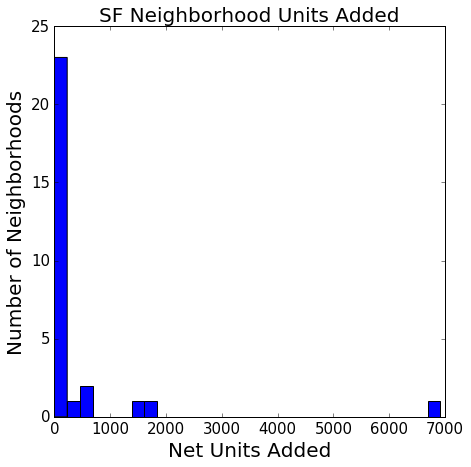

In [134]:
plt.title('SF Neighborhood Units Added', fontsize = 20)
plt.hist(df['net_units'], bins = 30, color='blue')
plt.xlabel('Net Units Added', fontsize = 20)
plt.ylabel('Number of Neighborhoods', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig(export+"/hist2.png",dpi=200)

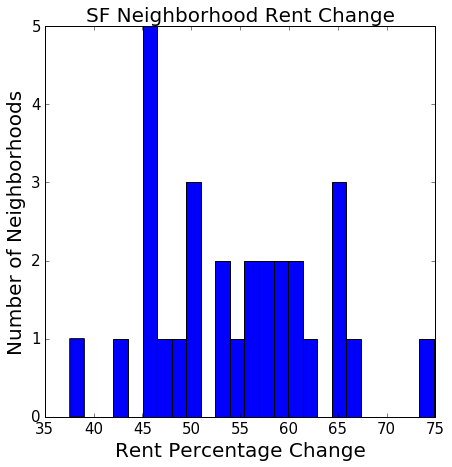

In [135]:
plt.title('SF Neighborhood Rent Change', fontsize = 20)
plt.hist(df['change'], bins = 25, color='blue')
plt.xlabel('Rent Percentage Change', fontsize = 20)
plt.ylabel('Number of Neighborhoods', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig(root+"2010_racial_distributuon_bay_area.png",dpi=150)
plt.savefig(export+"/hist1.png",dpi=200)

In [136]:
#Use OLS to estimate price based on square feet.
results = smf.ols('change ~  net_units', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     2.902
Date:                Sun, 04 Dec 2016   Prob (F-statistic):             0.0999
Time:                        18:38:16   Log-Likelihood:                -101.40
No. Observations:                  29   AIC:                             206.8
Df Residuals:                      27   BIC:                             209.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     55.5678      1.619     34.324      0.0

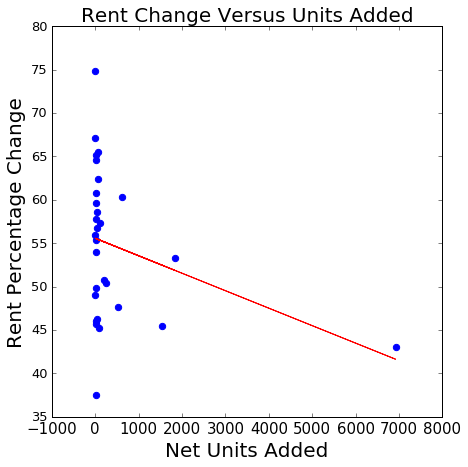

In [137]:
#Set export path
export = root+"/Output/"
fig, ax = plt.subplots()
plt.title('Rent Change Versus Units Added', fontsize = 20)
plt.xlabel('Net Units Added', fontsize = 20)
plt.ylabel('Rent Percentage Change', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
fit = np.polyfit(df['net_units'], df['change'], deg=1)
ax.plot(df['net_units'], fit[0] * df['net_units'] + fit[1], color='red')
ax.scatter(df['net_units'], df['change'], color='blue', alpha=1, s=40)
plt.savefig(export+"/reg1.png",dpi=200)

In [138]:
#Use OLS to estimate correlation between net units and average rent
results = smf.ols('avg_rent ~  net_units', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               avg_rent   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.2862
Date:                Sun, 04 Dec 2016   Prob (F-statistic):              0.597
Time:                        18:38:16   Log-Likelihood:                -256.30
No. Observations:                  29   AIC:                             516.6
Df Residuals:                      27   BIC:                             519.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4366.4515    338.070     12.916      0.0

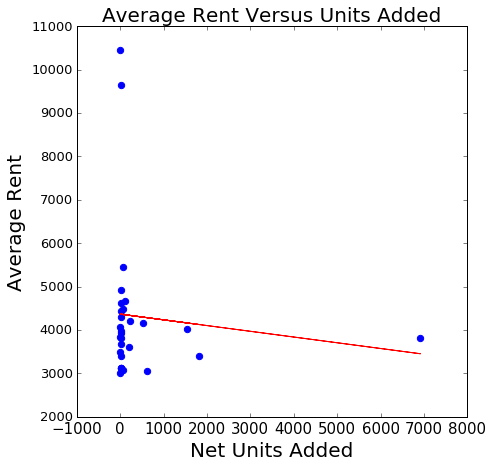

In [139]:
fig, ax = plt.subplots()
plt.title('Average Rent Versus Units Added', fontsize = 20)
plt.xlabel('Net Units Added', fontsize = 20)
plt.ylabel('Average Rent', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
fit = np.polyfit(df['net_units'], df['avg_rent'], deg=1)
ax.plot(df['net_units'], fit[0] * df['net_units'] + fit[1], color='red')
ax.scatter(df['net_units'], df['avg_rent'], color='blue', alpha=1, s=40)
plt.savefig(export+"/reg2.png",dpi=200)